In [61]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
import sys
import os
import yaml
import json
import pandas as pd
sys.path.append(".")
sys.path.append("../")
sys.path.append("../../")
import numpy as np
import src.utils.io as io   
import torch
import config as config
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
import src.utils.preprocess as preprocess
from src.eval.eval_utils import evaluate_label_distribution
from torch.utils.data import DataLoader

import src.methods.dann as dann
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [64]:
# Graphing Parameters
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

mpl.rcParams['lines.markersize'] = 12
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['xtick.labelsize'] = 25
mpl.rcParams['ytick.labelsize'] = 25
mpl.rcParams["axes.labelsize"] = 25
mpl.rcParams['legend.fontsize'] = 20
mpl.rcParams['axes.titlesize'] = 25
mpl.rcParams['text.usetex'] = True

In [65]:
print("Loading source data (Vectronics)...")
with open(config.VECTRONICS_PREPROCESSING_YAML) as f:
    Vectronics_preprocessing_config = yaml.safe_load(f)
Vectronics_feature_cols = Vectronics_preprocessing_config['feature_cols']

min_duration_before_padding = 15.0
vectronics_df = pd.read_csv(io.get_Vectronics_preprocessed_path(min_duration_before_padding))
X_src = vectronics_df[Vectronics_feature_cols].values
y_src = vectronics_df['behavior'].values
label_encoder = LabelEncoder()
y_src = label_encoder.fit_transform(y_src)

print("Loading target data (RVC)...")
RVC_df = pd.read_csv(io.get_RVC_preprocessed_path())
X_targets = [RVC_df.loc[RVC_df.firmware_major_version == 2.0, Vectronics_feature_cols].values,
            RVC_df.loc[RVC_df.firmware_major_version == 3.0, Vectronics_feature_cols].values]


Loading source data (Vectronics)...
Loading target data (RVC)...


In [66]:
# --------------------------
# Preprocess (compute quantiles using all domains)
# --------------------------
pos_idx = [0, 1, 2, 3, 4, 5]  # Indices of features that should be positive
center_idx = [6, 7, 8]  # Indices of features that should be centered at zero

# compute global lows/highs once
lows, highs = preprocess.compute_combined_quantiles(
    datasets=[X_src],
    pos_idx=pos_idx,
    center_idx=center_idx,
    low_q=0.00,
    high_q=1.00,
)

# define transform
transform = preprocess.TransformAndScale(
    pos_idx=pos_idx,
    center_idx=center_idx,
    lows=lows,
    highs=highs
)

X_src = transform(torch.tensor(X_src, dtype=torch.float32))
X_targets = [transform(torch.tensor(Xt, dtype=torch.float32)) for Xt in X_targets]
target_loaders = [DataLoader(Xt, batch_size=1024, shuffle=True, num_workers=4, pin_memory=True) for Xt in X_targets]

/tmp/ipykernel_3477478/984153823.py:48: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


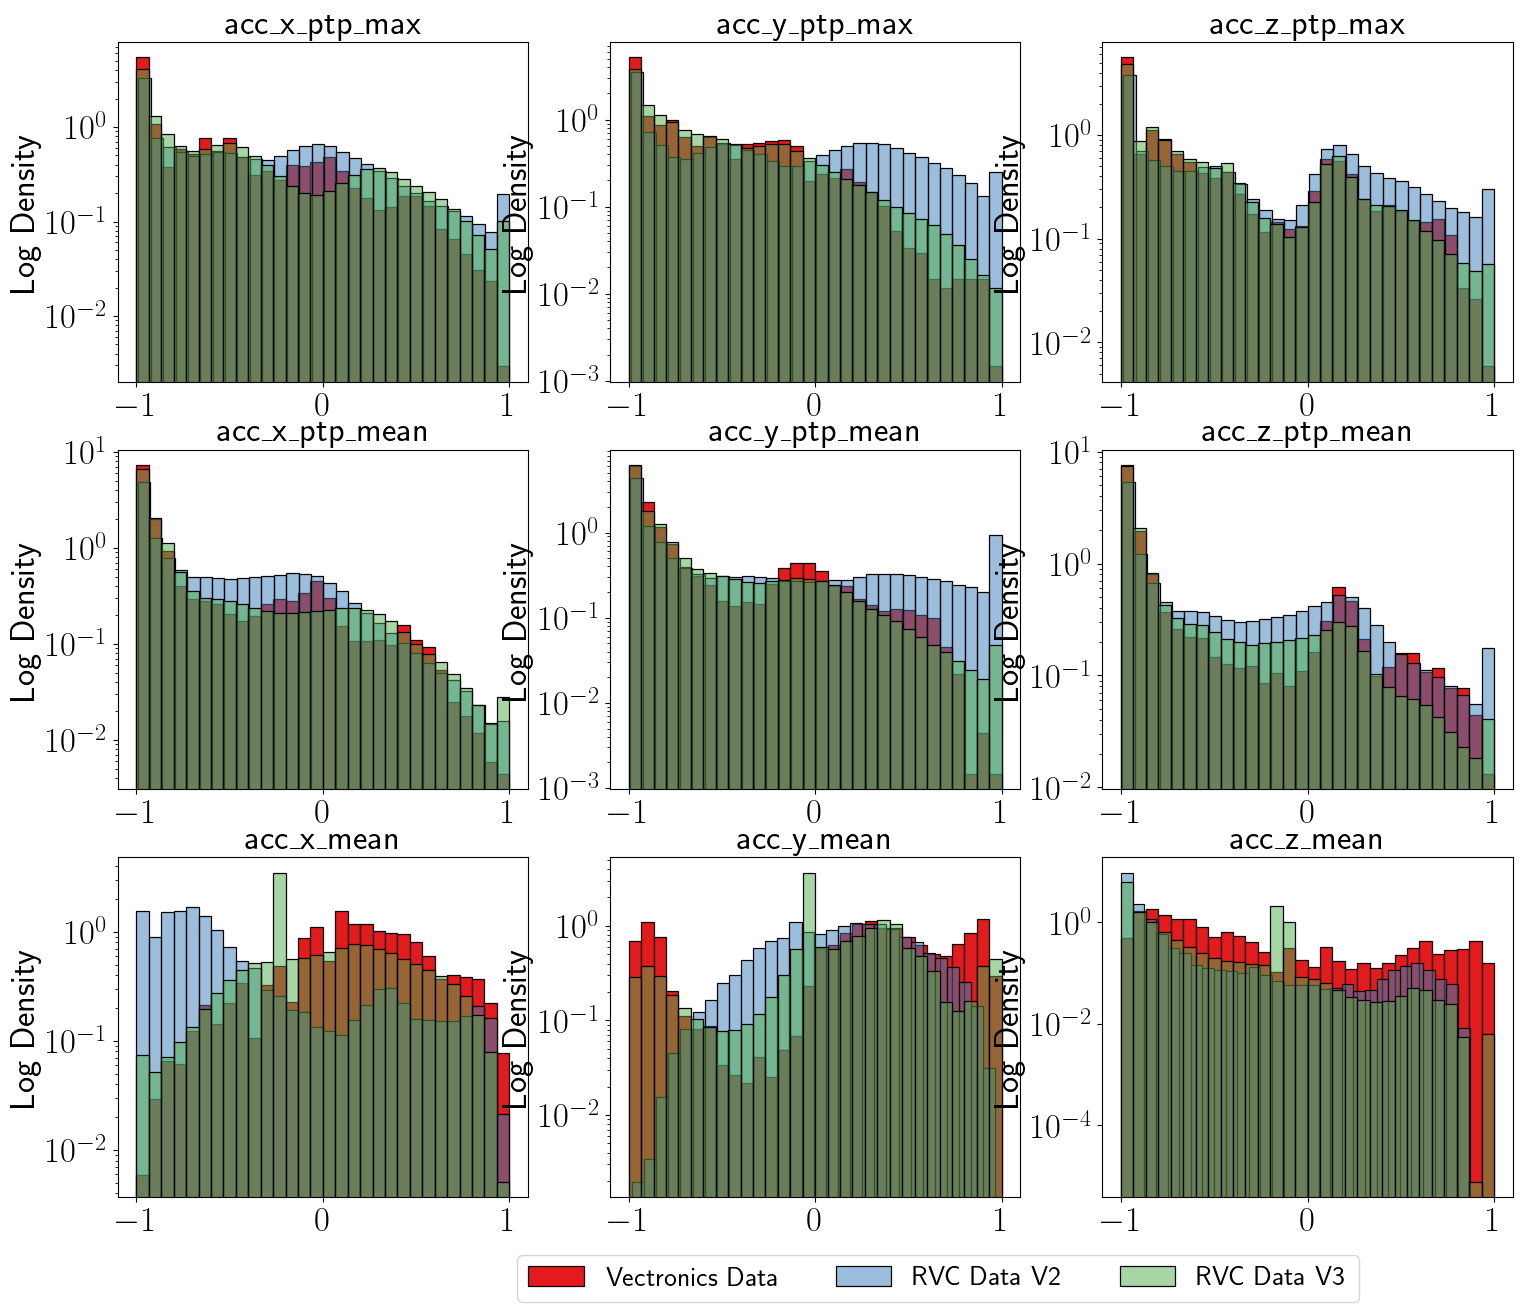

In [35]:
# Plot histograms of features
fig, axes = plt.subplots(len(Vectronics_feature_cols)//3, 3, figsize=(18, 5*(len(Vectronics_feature_cols)//3)))

palette = sns.color_palette("Set1", n_colors=3)
axes = axes.flatten()
for i, col in enumerate(Vectronics_feature_cols):
        ax = axes[i]

        sns.histplot(
                X_src[:,i].numpy(),
                kde=False,
                label='Vectronics Data',
                ax=ax,
                stat='density',
                bins=30,
                color=palette[0],
                alpha=1.0
            )

        sns.histplot(X_targets[0][:,i].numpy(),
                kde=False,
                label='RVC Data V2',
                ax=ax,
                stat='density',
                bins=30,
                color=palette[1],
                alpha=0.5
            )
        sns.histplot(X_targets[1][:,i].numpy(),
                kde=False,
                label='RVC Data V3',
                ax=ax,
                stat='density',
                bins=30,
                color=palette[2],
                alpha=0.5
            )
    
        ax.set_title(col)
        ax.set_ylabel('Log Density')
        ax.set_yscale("log")
        ax.set_xlabel('')

# Get legend info from the first axes
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles, labels, loc='lower center', bbox_to_anchor=(2.0, -2.75), ncol=3)

plt.tight_layout()
plt.show()


## Method 1: CORAL

In [67]:
dir1 = os.path.join(io.get_domain_adaptation_results_dir(), "coral", "target1")
dir2 = os.path.join(io.get_domain_adaptation_results_dir(), "coral", "target2")

with open(os.path.join(dir1, "training_stats.json"), 'r') as f:
    training_stats_list = json.load(f)
stats_df1 = pd.DataFrame(training_stats_list)
with open(os.path.join(dir2, "training_stats.json"), 'r') as f:
    training_stats_list = json.load(f)
stats_df2 = pd.DataFrame(training_stats_list)

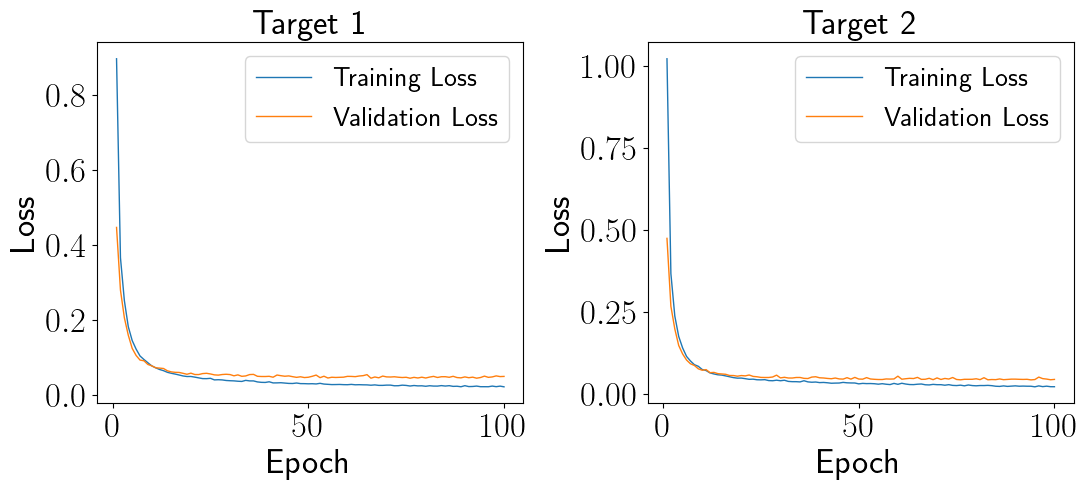

In [68]:
fig, axs = plt.subplots(1, 2, figsize=(11, 5))

axs[0].plot(stats_df1['epoch'], stats_df1['Training Loss'], label='Training Loss')
axs[0].plot(stats_df1['epoch'], stats_df1['Validation Loss'], label='Validation Loss')
axs[0].set_title('Target 1')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(stats_df2['epoch'], stats_df2['Training Loss'], label='Training Loss')
axs[1].plot(stats_df2['epoch'], stats_df2['Validation Loss'], label='Validation Loss')
axs[1].set_title('Target 2')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Loss')
axs[1].legend()

plt.tight_layout()
plt.show()

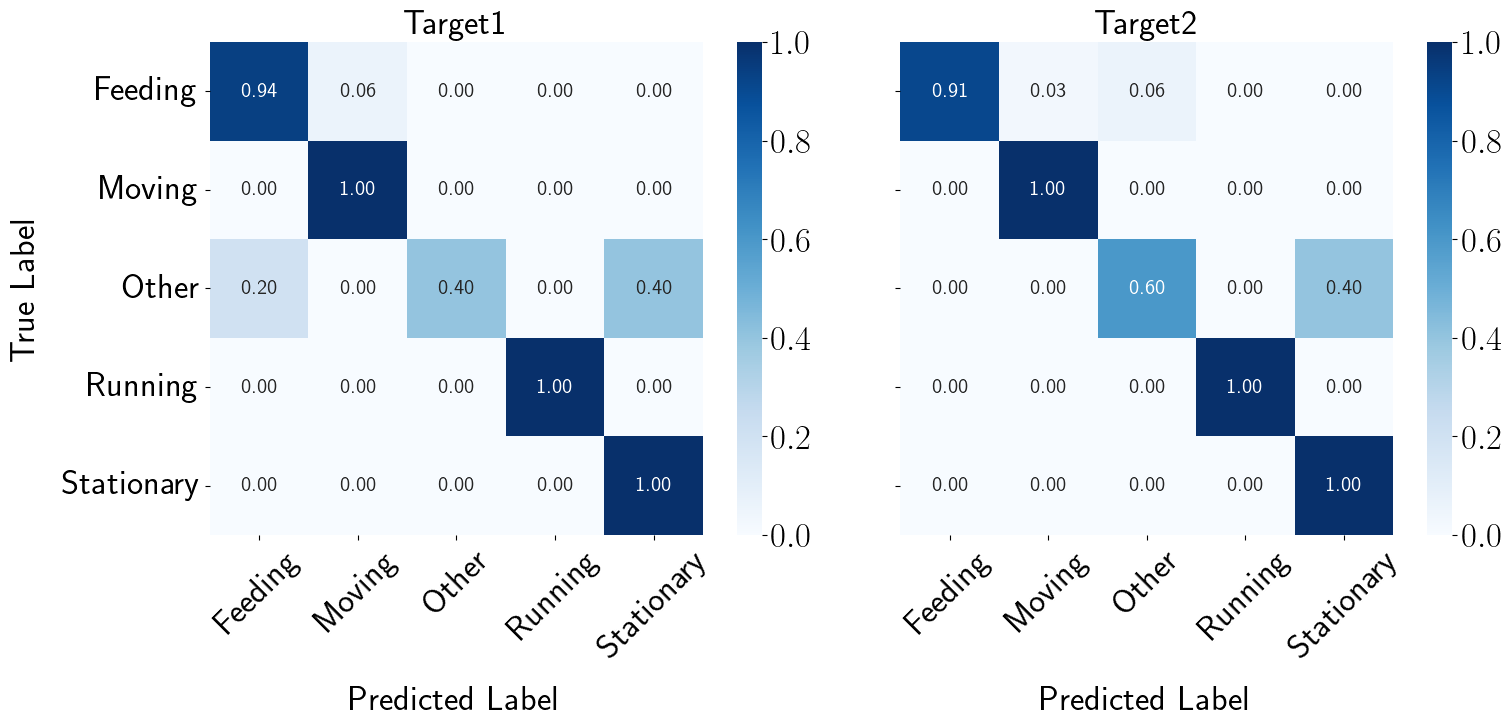

In [69]:
directories = [dir1, dir2]
fig, axes = plt.subplots(1, 2, figsize=(16, 7), sharey=True)
for i, dir_path in enumerate(directories):
    ax = axes[i] # Select the subplot to draw on (axes[0] or axes[1])
    
    # Load the results file
    test_results = np.load(os.path.join(dir_path, "test_results.npz"))
    test_true = test_results["true_classes"]
    test_preds = test_results["predictions"]
    
    # Calculate the confusion matrix
    cm = confusion_matrix(
        y_true=label_encoder.inverse_transform(test_true),
        y_pred=label_encoder.inverse_transform(test_preds),
        labels=class_names,
        normalize='true' # Normalize to show proportions
    )
    
    # Plot the heatmap on the selected subplot
    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names,
                cbar=True, square=True, annot_kws={"size": 15}, ax=ax)
    
    # Customize labels and titles for each subplot
    ax.set_title(f"Target{i+1}")
    ax.set_xlabel("Predicted Label", labelpad=15)
    
    # Only show the y-label on the first plot
    if i == 0:
        ax.set_ylabel("True Label", labelpad=15)
    
    ax.tick_params(axis='x', rotation=45)
    ax.tick_params(axis='y', rotation=0)

# Adjust layout to prevent labels from overlapping and display the plot
plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust rect to make space for suptitle
plt.show()

In [51]:
for i, dir_path in enumerate(directories):
    model = torch.load(os.path.join(dir, "model.pt")).to(device)
    _ = evaluate_label_distribution(model=model, 
                                    data=target_loaders[i],
                                    n_classes=len(np.unique(y_src)), 
                                    label_encoder=label_encoder,
                                    device=device, )

/tmp/ipykernel_2626723/4008831470.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(os.path.join(dir, "model.pt")).to(device)
Evaluating: 100%|█████████

Class Feeding: 30.910
Class Moving: 2.510
Class Other: 9.230
Class Running: 3.220
Class Stationary: 54.130


Evaluating: 100%|██████████| 5689/5689 [00:15<00:00, 376.27it/s]

Class Feeding: 3.850
Class Moving: 11.640
Class Other: 2.540
Class Running: 4.380
Class Stationary: 77.590


## Method 2: DANN

In [56]:
dir = os.path.join(io.get_domain_adaptation_results_dir(), "dann")

with open(os.path.join(dir1, "training_stats.json"), 'r') as f:
    training_stats_list = json.load(f)
stats_df = pd.DataFrame(training_stats_list)

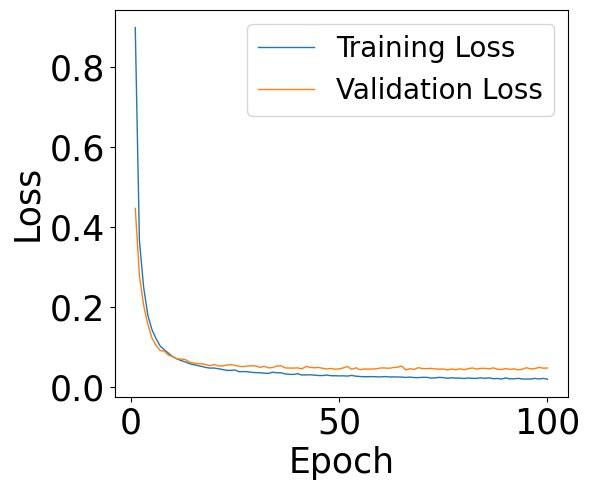

In [57]:
plt.figure(figsize=(6, 5))

plt.plot(stats_df1['epoch'], stats_df1['Training Loss'], label='Training Loss')
plt.plot(stats_df1['epoch'], stats_df1['Validation Loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

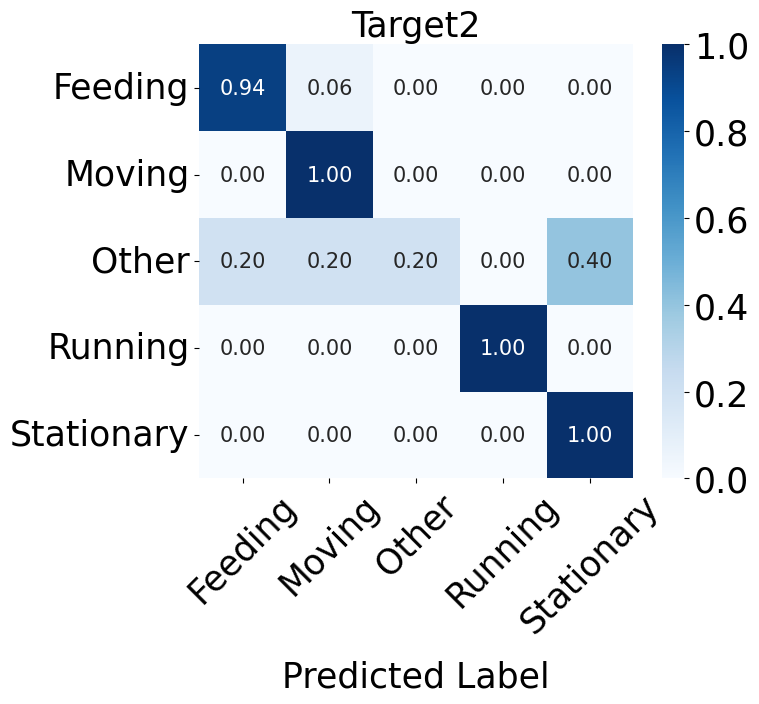

In [58]:

fig, ax = plt.subplots(figsize=(8, 7), sharey=True)

# Load the results file
test_results = np.load(os.path.join(dir, "test_results.npz"))
test_true = test_results["true_classes"]
test_preds = test_results["predictions"]

# Calculate the confusion matrix
cm = confusion_matrix(
    y_true=label_encoder.inverse_transform(test_true),
    y_pred=label_encoder.inverse_transform(test_preds),
    labels=class_names,
    normalize='true' # Normalize to show proportions
)

# Plot the heatmap on the selected subplot
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names,
            cbar=True, square=True, annot_kws={"size": 15}, ax=ax)

# Customize labels and titles for each subplot
ax.set_title(f"Target{i+1}")
ax.set_xlabel("Predicted Label", labelpad=15)

# Only show the y-label on the first plot
if i == 0:
    ax.set_ylabel("True Label", labelpad=15)

ax.tick_params(axis='x', rotation=45)
ax.tick_params(axis='y', rotation=0)

# Adjust layout to prevent labels from overlapping and display the plot
plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust rect to make space for suptitle
plt.show()

In [59]:
for loader in target_loaders:
    model = torch.load(os.path.join(dir, "model.pt")).to(device)
    _ = evaluate_label_distribution(model=model, 
                                    data=loader,
                                    n_classes=len(np.unique(y_src)), 
                                    label_encoder=label_encoder,
                                    device=device, )

/tmp/ipykernel_2626723/1443378535.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(os.path.join(dir, "model.pt")).to(device)
Evaluating:   0%|         

Evaluating: 100%|██████████| 1223/1223 [00:03<00:00, 381.98it/s]
/tmp/ipykernel_2626723/1443378535.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(os.

Class Feeding: 25.310
Class Moving: 3.350
Class Other: 2.870
Class Running: 5.190
Class Stationary: 63.290


Evaluating: 100%|██████████| 5689/5689 [00:13<00:00, 411.47it/s]

Class Feeding: 2.220
Class Moving: 13.300
Class Other: 1.020
Class Running: 4.440
Class Stationary: 79.020
